<a href="https://colab.research.google.com/github/DOptimusPrime/AI_Soil_Modeling/blob/main/camclay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Modified Cam Clay model is based on the following model of conservation of energy.

\begin{align}
dW = p^\prime d\varepsilon_v^p + qd\varepsilon_v^s
\end{align}

For the internal work it is assumed that when a sample is consolidated isotropically it will experience no deviatoric strain, thus:

\begin{align}
    dW(q=0) = p^\prime d\varepsilon_v^p + 0 
\end{align}

Similarly, it was assumed that at critical state there will be no volumetric strain:

\begin{align}
    dW(q = Mp^\prime) = p^\prime d\varepsilon_s^p + 0 
\end{align}    
The resultant of these two extremes is assumed to represent the soil during any other state:

\begin{align}
    dW &= \sqrt{(p^\prime d\varepsilon_v^p)^2 + (p^\prime d\varepsilon_s^p)^2}\\
    &= p^\prime\sqrt{(d\varepsilon_v^p)^2 + (d\varepsilon_s^p)^2}\\
\end{align}

Equating the internal and the external work:
\begin{align}
    dW_{ext} &= dW_{int}\\
    p^\prime d\varepsilon_v^p + qd\varepsilon_v^s &= p^\prime\sqrt{(d\varepsilon_v^p)^2 + (d\varepsilon_s^p)^2}\\
    \Rightarrow \frac{d\varepsilon^p_v}{d\varepsilon^p_s}&=\frac{-dq}{dp^\prime} = \frac{M^2-\eta^2}{2\eta}
\end{align}

Integrating:
\begin{align}
    F(q, p) = q^2 - M^2p^2\big(\frac{p^\prime_c}{p^\prime}-1\big) = 0
\end{align}

Which is the flow rule and yield surface for the modified Cam Clay model.

The stress increment for an elasto-plastic material can be calculated as:

\begin{align}
    d\sigma &= D^e(d\varepsilon - d\varepsilon^p)\\
\end{align}

$d\varepsilon^p$ can be shown to equal:

\begin{align}
d\varepsilon^p = 
    \frac{\partial G}{\partial \sigma^\prime}\frac{\big(\frac{\partial F}{\partial \sigma}\big)^T D^ed\varepsilon}{\big(\frac{\partial F}{\partial \sigma}\big)^T D^e \big(\frac{\partial G}{\partial \sigma}\big) + H}, \quad \text{where }H = \frac{dW_p}{d\varepsilon^p}
\end{align}

Subsequently, the D-matrix can be compiled as:

\begin{align}
D^{ep} =
    \begin{bmatrix}
        D^e - \frac{D^e \big(\frac{\partial G}{\partial \sigma^\prime}\big)\big(\frac{\partial F}{\partial \sigma^\prime}\big)^T D^e } {-\big(\frac{\partial F}{\partial W_p}\big)\big(\frac{\partial W_p}{\partial \varepsilon^p}\big)\big(\frac{\partial G}{\partial \sigma^\prime}\big) + \big(\frac{\partial F}{\partial \sigma^\prime}\big)^T D^e \big(\frac{\partial G}{\partial \sigma^\prime}\big)}
    \end{bmatrix}
\end{align}

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Input Parameters
M = 0.95
Lambda = 0.16
Kappa = 0.06
Poisson = 0.2
N = 2.7
Pc = 100
P0 = 100

'''
M = float(input('Enter the slope of CSL in q-p space, M: '))
Lambda = float(input('Enter the value of lambda: '))
Kappa = float(input('Enter the value of kappa: '))
N = float(input('Enter the value of specifc volume at unit pressure, N: '))
Poisson = float(input('Enter the value of effective Poisson ratio: '))
Pc = float(input('Enter the consolidation pressure: '))
P0 = float(input('Enter the confining pressure: '))
'''

# Controls

Iterations = 20000
Inc_Strain = 0.00001


# Matrices
De = np.zeros((6,6))
dFds = np.zeros((6,1))
u = np.zeros((Iterations,1))
p = np.zeros((Iterations,1))
q = np.zeros((Iterations,1))
e = np.zeros((Iterations,1))
u = np.zeros((Iterations,1))



# Initial State Calculations

V = N - Lambda*np.log(Pc) + Kappa*np.log(Pc/P0)



e[0] = V - 1


print('The initial void ratio before shearing is: %.3f' %e[0])

Stress = np.array([[P0], [P0], [P0], [0], [0], [0]])
Strain = np.array([[0], [0], [0], [0], [0], [0]])
p[0] = (Stress[0] + Stress[1] + Stress[2])/3
q[0] = Stress[0] - Stress[2]
F = q[0]**2 + (M*p[0])**2 - p[0]*Pc*M**2

# Computations
for Iteration in range(Iterations):
    
    e[Iteration] = V-1 # Void Ratio 
    
    
    p[Iteration] = (Stress[0] + Stress[1] + Stress[2])/3 # Mean Stress
    q[Iteration] = Stress[0] - Stress[2] # Deviatoric Stress
    
    u[Iteration] = q[Iteration]/3 + P0 - p[Iteration] # This is the distance btween total and effective stress paths
    
    if F < 0: # Did not yield; calculate new F
        F = q[Iteration]**2 + (M*p[Iteration])**2 - p[Iteration]*Pc*M**2
    else: # Stress state is on yield surface; calculate new Pc
        F = 0
        Pc = ((q[Iteration]/M)**2 + (p[Iteration])**2)/p[Iteration]
        print(Pc)
    
    # Formulate elastic stiffness matrix 
    K = V*p[Iteration]/Kappa # K is the Bulk Modulus
    G = 3*K*(1-2*Poisson)/(2*(1+Poisson)) # G is the Shear Modulus
    
    for row in range(6): # Loop through rows 0 to 5
        for column in range(6): # Loop through columns 0 to 5
            if row == column and row <= 2:
                De[row,column] = K + 4*G/3
            elif row == column and row > 2:
                De[row,column] = G
            elif row <= 2 and column <= 2:
                De[row,column] = K - 2*G/3
                
    
    # Check if stress state reached yield
    if F < 0: # Not on yield surface; elastic matrix
        D = De
    else: # Stress state is on yiled surface; need to formulate new D-matrix
        
        for row in range(6): # Formulate 1x6 dF/dsigma matrix
            if row < 3:
                dFds[row] = (2*p[Iteration] - Pc)/3 + 3*(Stress[row]-p[Iteration])/M**2
            else:
                dFds[row] = 6*Stress[row]/M**2
                
        DexdFds = np.matmul(De,dFds)

        
        DexdFdsxdFdsT = np.matmul(DexdFds,np.transpose(dFds))
        dFdsTxDe = np.matmul(np.transpose(dFds),De)
    # d matrix 
        D = De - ((np.matmul(DexdFdsxdFdsT,De))/(-(-p[Iteration]*V*Pc*(2*p[Iteration]-Pc)/(Lambda-Kappa))+np.matmul(dFdsTxDe,dFds)))

    dStrain = np.array([[Inc_Strain], [-0.5*Inc_Strain], [-0.5*Inc_Strain], [0], [0], [0]]) # Undrained
    dStress = np.matmul(D,dStrain) # Stress Increment
    Stress = Stress + dStress
    Strain = Strain + dStrain
    
    V = N - Lambda*np.log(Pc) + Kappa*np.log(Pc/p[Iteration]) # Update volume
 

Streaming output truncated to the last 5000 lines.
[129.68974738]
[129.68975662]
[129.68976585]
[129.68977508]
[129.68978431]
[129.68979353]
[129.68980275]
[129.68981196]
[129.68982116]
[129.68983037]
[129.68983957]
[129.68984876]
[129.68985795]
[129.68986713]
[129.68987631]
[129.68988549]
[129.68989466]
[129.68990383]
[129.68991299]
[129.68992215]
[129.6899313]
[129.68994045]
[129.68994959]
[129.68995873]
[129.68996786]
[129.68997699]
[129.68998612]
[129.68999524]
[129.69000436]
[129.69001347]
[129.69002258]
[129.69003168]
[129.69004078]
[129.69004987]
[129.69005896]
[129.69006805]
[129.69007713]
[129.6900862]
[129.69009527]
[129.69010434]
[129.6901134]
[129.69012246]
[129.69013151]
[129.69014056]
[129.69014961]
[129.69015864]
[129.69016768]
[129.69017671]
[129.69018574]
[129.69019476]
[129.69020378]
[129.69021279]
[129.6902218]
[129.6902308]
[129.6902398]
[129.69024879]
[129.69025778]
[129.69026677]
[129.69027575]
[129.69028473]
[129.6902937]
[129.69030267]
[129.69031163]
[129.690320

In [23]:
print(Stress)

[[105.92926379]
 [ 44.31854285]
 [ 44.31854285]
 [  0.        ]
 [  0.        ]
 [  0.        ]]


## Modified Cam Clay

[[ 0.        ]
 [ 0.07361898]
 [ 0.14723768]
 ...
 [61.61071984]
 [61.61072021]
 [61.61072057]]


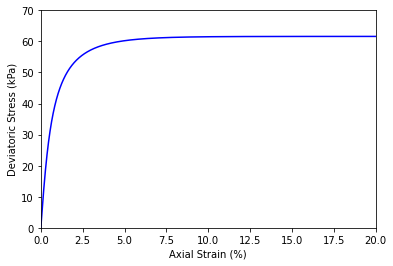

In [39]:
from operator import index
# Plot q vs axial strain

Axial_Strain = np.linspace(0,Inc_Strain*100.*(Iterations-1),Iterations)  
plt.figure(figsize=(6,4))
plt.plot(Axial_Strain, q, color='b');
plt.xlim(0, Iterations*Inc_Strain*100)
plt.ylim(0,np.ceil(max(q)/10)*10)
plt.ylabel('Deviatoric Stress (kPa)');
plt.xlabel('Axial Strain (%)');
print(q)


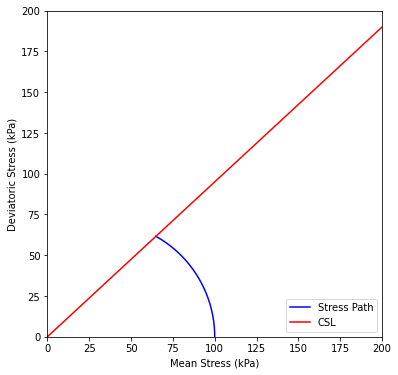

In [25]:
# Plot stress path in q-p' plane

plt.figure(figsize=(6,6))
plt.plot(p, q, color='b', label='Stress Path');
Max_Stress = np.maximum(np.ceil(np.max(p+1)/100)*100,np.ceil(np.max(q+1)/100)*100)
plt.plot([0, Max_Stress], [0, Max_Stress*M], color='r', label='CSL');
plt.xlim(0, Max_Stress)
plt.ylim(0, Max_Stress)
plt.ylabel('Deviatoric Stress (kPa)');
plt.xlabel('Mean Stress (kPa)');
plt.legend(loc='lower right');

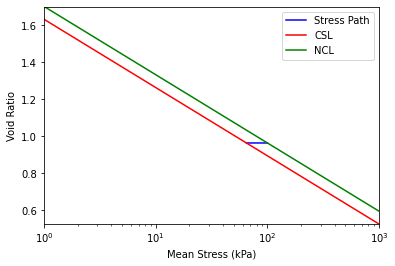

In [26]:
# Plot stress path in v-ln p' plane

plt.figure(figsize=(6,4))
plt.semilogx(p,e, color='b', label='Stress Path')
plt.semilogx([1,1000],[N-(Lambda-Kappa)*np.log(2)-1,N-(Lambda-Kappa)*np.log(2)-Lambda*np.log(1000)-1], color='r', label='CSL')
plt.semilogx([1,1000],[N-1,N-Lambda*np.log(1000)-1], color='g', label='NCL')
plt.xlim(1, np.ceil(np.max(q)/1000)*1000)
plt.ylim(N-(Lambda-Kappa)*np.log(2)-Lambda*np.log(np.ceil(np.max(q)/1000)*1000)-1,N-1)
plt.ylabel('Void Ratio');
plt.xlabel('Mean Stress (kPa)');
plt.legend(loc='upper right');

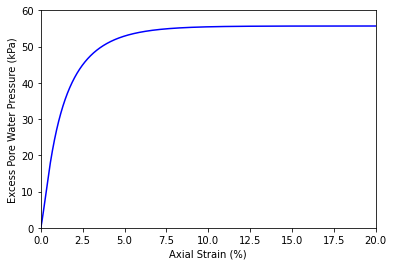

In [27]:
# Plot excess pore pressure vs axial strain

plt.figure(figsize=(6,4))
plt.plot(Axial_Strain, u, color='b');
plt.xlim(0, Iterations*Inc_Strain*100)
plt.ylim(np.floor(np.min(u)/10)*10,np.ceil(np.max(u)/10)*10)
plt.ylabel('Excess Pore Water Pressure (kPa)');
plt.xlabel('Axial Strain (%)');

In [28]:
data = {'Stress':Stress.tolist(),'Strain':Strain.tolist()}

In [29]:
df = pd.DataFrame()
df["Stress"] = Stress.tolist()
df["Strain"] = Strain.tolist()


In [30]:
df

,Stress,Strain
0,[105.92926378846848],[0.20000000000005924]
1,[44.31854285093293],[-0.10000000000002962]
2,[44.31854285093292],[-0.10000000000002962]
3,[0.0],[0.0]
4,[0.0],[0.0]
5,[0.0],[0.0]


In [31]:
df['Strain'] = Strain

In [32]:
df = pd.DataFrame(data)

In [33]:
df

,Stress,Strain
0,[105.92926378846848],[0.20000000000005924]
1,[44.31854285093293],[-0.10000000000002962]
2,[44.31854285093292],[-0.10000000000002962]
3,[0.0],[0.0]
4,[0.0],[0.0]
5,[0.0],[0.0]


In [34]:
df.to_csv("datacrap.csv")

In [66]:
import pandas as pd
df = pd.DataFrame( Pc)

df2 = df.assign()
df.to_csv('mypcvalue.csv')

In [67]:

df

,0
0,129.70678


# New Section